<a href="https://colab.research.google.com/github/ZeroToH3ro/Predictive-Model-Advance/blob/main/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import warnings

# Keep notebook output clean.
os.environ["PYTHONWARNINGS"] = "ignore"
warnings.simplefilter("ignore")

import numpy as np

# Suppress NumPy floating-point warnings (e.g., divide-by-zero) that can appear during modeling.
np.seterr(all="ignore")

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [35]:
# Sequence encoding removed.
# This notebook now runs a RAS-only pipeline using `data/data_RAS.xlsx`.


In [36]:
def load_ras_features(ras_path, sheet_name="Sheet1"):
    ras_df = pd.read_excel(ras_path, sheet_name=sheet_name)
    if "Accession number" not in ras_df.columns:
        raise ValueError("Accession number column missing in RAS file.")

    drop_cols = {col for col in ras_df.columns if col.lower() in {"no", "id"}}
    genotype_cols = [col for col in ras_df.columns if col.lower() == "genotype"]

    features = pd.DataFrame({"Accession number": ras_df["Accession number"]})

    numeric_cols = ras_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in drop_cols and col != "Accession number"]
    if numeric_cols:
        features = pd.concat([features, ras_df[numeric_cols]], axis=1)

    for gen_col in genotype_cols:
        gen_series = ras_df[gen_col].astype(str).str.strip()
        gen_series = gen_series.replace({"nan": np.nan, "None": np.nan, "": np.nan})
        dummies = pd.get_dummies(gen_series, prefix=gen_col)
        features = pd.concat([features, dummies], axis=1)

    mutation_cols = []
    for col in ras_df.columns:
        if col in drop_cols or col == "Accession number" or col in genotype_cols or col in numeric_cols:
            continue
        col_type = ras_df[col].dtype
        if col_type == object or str(col_type) == "string":
            name = col.lower()
            if any(key in name for key in ["mut", "mutation", "resistance", "ras"]):
                mutation_cols.append(col)

    if mutation_cols:
        import re

        def count_mutations(val):
            if pd.isna(val):
                return 0
            if isinstance(val, (int, float)) and not isinstance(val, bool):
                if np.isnan(val):
                    return 0
                return int(val)
            s = str(val).strip()
            if not s or s.lower() in {"nan", "none", "na"}:
                return 0
            if re.fullmatch(r"[-+]?\d+(\.\d+)?", s):
                return int(float(s))
            s = s.strip("[]()")
            parts = [part for part in re.split(r"[;,\s]+", s) if part]
            return len(parts)

        for col in mutation_cols:
            features[col] = ras_df[col].apply(count_mutations).astype(float)

    return features


def build_target(response_series):
    response_map = {
        "SVR": 0,
        "Non SVR": 1,
    }
    response_series = response_series.astype(str).str.strip()
    y = response_series.map(response_map)
    if y.isna().any():
        bad_values = sorted(response_series[y.isna()].unique())
        raise ValueError(f"Unmapped Respond values: {bad_values}")
    return y.values


In [37]:
def build_feature_matrix(ras_path, ras_sheet="Sheet1"):
    ras_raw = pd.read_excel(ras_path, sheet_name=ras_sheet)
    ras_raw["Accession number"] = ras_raw["Accession number"].astype(str).str.strip()

    if "Respond" not in ras_raw.columns:
        raise ValueError("Respond column missing in RAS file; cannot build targets.")

    ras_features = load_ras_features(ras_path, sheet_name=ras_sheet)
    ras_features["Accession number"] = ras_features["Accession number"].astype(str).str.strip()

    ras_features = ras_features.set_index("Accession number").loc[ras_raw["Accession number"]].reset_index()

    ras_cols = [c for c in ras_features.columns if c != "Accession number"]
    X = ras_features[ras_cols].to_numpy().astype(float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    y = build_target(ras_raw["Respond"])
    feature_names = ras_cols
    return X, y, ras_raw, ras_features, feature_names


In [38]:
def optimize_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    finite_mask = np.isfinite(thresholds)
    if finite_mask.any():
        thresholds = thresholds[finite_mask]
        fpr = fpr[finite_mask]
        tpr = tpr[finite_mask]
    else:
        return 0.5, fpr, tpr

    youden = tpr - fpr
    best_idx = np.argmax(youden)
    return thresholds[best_idx], fpr, tpr


def plot_roc_curve(fpr, tpr, auc_score, label):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=3, label=f"{label} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [39]:
def train_and_evaluate_models(X, y, seq_df, feature_names, label="", save_path=None, include_xgboost=True):
    try:
        from xgboost import XGBClassifier
        has_xgb = True
    except ImportError:
        has_xgb = False
        if include_xgboost:
            print("xgboost not installed; skipping XGBoost model.")

    if save_path is None:
        save_path = os.path.join(os.getcwd(), "ml_results")
    os.makedirs(save_path, exist_ok=True)

    print(f"Label: {label}")
    print("Class distribution:", pd.Series(y).value_counts().to_dict())

    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=0.4, random_state=42, stratify=y
    )

    base_steps = [
        ("var", VarianceThreshold()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("finite", FiniteClipper()),
    ]

    models = [
        {
            "name": "SVM",
            "estimator": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
            "param_grid": {
                "model__C": [0.1, 1, 10],
                "model__gamma": ["scale", 0.1, 0.01],
            },
            "extra_steps": [("pca", PCA(n_components=0.95, svd_solver="full", random_state=42))],
        },
        {
            "name": "Elastic Net",
            "estimator": LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                max_iter=5000,
                class_weight="balanced",
            ),
            "param_grid": {
                "model__C": [0.01, 0.1, 1, 10],
                "model__l1_ratio": [0.1, 0.5, 0.9],
            },
        },
        {
            "name": "Random Forest",
            "estimator": RandomForestClassifier(random_state=42, class_weight="balanced"),
            "param_grid": {
                "model__n_estimators": [300, 500],
                "model__max_depth": [None, 20],
                "model__min_samples_leaf": [1, 2],
            },
        },
        {
            "name": "GBM",
            "estimator": GradientBoostingClassifier(random_state=42),
            "param_grid": {
                "model__n_estimators": [200, 400],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [2, 3],
            },
        },
        {
            "name": "Decision Tree",
            "estimator": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
            "param_grid": {
                "model__max_depth": [3, 5, None],
                "model__min_samples_leaf": [1, 2],
            },
        },
    ]

    if include_xgboost and has_xgb:
        pos = y_train.sum()
        neg = len(y_train) - pos
        scale_pos_weight = float(neg) / pos if pos > 0 else 1.0
        models.append({
            "name": "XGBoost",
            "estimator": XGBClassifier(
                random_state=42,
                eval_metric="logloss",
                tree_method="hist",
                scale_pos_weight=scale_pos_weight,
            ),
            "param_grid": {
                "model__n_estimators": [300, 500],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [3, 5],
                "model__subsample": [0.8, 1.0],
                "model__colsample_bytree": [0.8, 1.0],
            },
        })

    metrics = []
    preds_df = pd.DataFrame({
        "Accession number": seq_df.iloc[idx_test]["Accession number"].values,
        "True_Label": y_test,
    })
    model_results = {}

    for cfg in models:
        print(f"\nTraining {cfg['name']}...")
        steps = list(base_steps)
        if cfg.get("extra_steps"):
            steps.extend(cfg["extra_steps"])
        steps.append(("model", cfg["estimator"]))

        pipeline = Pipeline(steps=steps)
        search = GridSearchCV(pipeline, cfg["param_grid"], scoring="roc_auc", cv=5, n_jobs=1)
        search.fit(X_train, y_train)

        model = search.best_estimator_
        print(f"Best params for {cfg['name']}: {search.best_params_}")
        print(f"Best CV ROC-AUC: {search.best_score_:.4f}")

        y_proba = model.predict_proba(X_test)[:, 1]
        threshold, fpr, tpr = optimize_threshold(y_test, y_proba)
        y_pred = (y_proba >= threshold).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_proba)

        metrics.append({
            "Model": cfg["name"],
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1_Score": f1,
            "AUC_Score": auc_score,
            "Threshold": threshold,
        })

        col_base = cfg["name"].replace(" ", "_")
        preds_df[f"Pred_{col_base}"] = y_pred
        preds_df[f"Prob_{col_base}"] = np.round(y_proba * 100, 2)

        model_results[cfg["name"]] = {
            "model": model,
            "threshold": threshold,
            "metrics": metrics[-1],
            "fpr": fpr,
            "tpr": tpr,
            "y_pred": y_pred,
            "y_proba": y_proba,
        }

        if cfg["name"] == "SVM":
            print(f"Optimal threshold (Youden): {threshold:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"AUC Score: {auc_score:.4f}")
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred))
            plot_roc_curve(fpr, tpr, auc_score, label=label or cfg["name"])

    label_map = {0: "Success", 1: "Failure"}
    preds_df["True_Label"] = preds_df["True_Label"].map(label_map)
    for col in preds_df.columns:
        if col.startswith("Pred_"):
            preds_df[col] = preds_df[col].map({0: "Success", 1: "Failure"})

    preds_path = os.path.join(save_path, f"ensemble_predictions_{label}.xlsx")
    preds_df.to_excel(preds_path, index=False)

    metrics_df = pd.DataFrame(metrics)
    metrics_path = os.path.join(save_path, f"model_metrics_{label}.xlsx")
    metrics_df.to_excel(metrics_path, index=False)

    return {
        "models": model_results,
        "metrics": metrics_df,
        "predictions": preds_df,
        "X_train": X_train,
        "X_test": X_test,
        "y_test": y_test,
        "feature_names": feature_names,
        "save_path": save_path,
    }


In [40]:
def explain_with_shap(model, X_train, X_test, feature_names, max_background=50, max_samples=20, save_path=None, label=""):
    try:
        import shap
    except ImportError:
        print("SHAP not installed; skipping explainability.")
        return

    rng = np.random.RandomState(42)
    bg_size = min(max_background, len(X_train))
    sample_size = min(max_samples, len(X_test))

    background = X_train[rng.choice(len(X_train), size=bg_size, replace=False)]
    samples = X_test[:sample_size]

    print("Running SHAP on a small sample for explainability...")
    explainer = shap.KernelExplainer(model.predict_proba, background)
    shap_values = explainer.shap_values(samples, nsamples=100)

    if isinstance(shap_values, list):
        shap_matrix = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_matrix = shap_values
        if shap_matrix.ndim == 3:
            shap_matrix = shap_matrix[:, :, 1] if shap_matrix.shape[-1] > 1 else shap_matrix[:, :, 0]

    # Some SHAP versions include a final bias column; drop if present.
    if shap_matrix.shape[1] == samples.shape[1] + 1:
        shap_matrix = shap_matrix[:, :-1]

    if shap_matrix.shape[0] != samples.shape[0] and shap_matrix.shape[1] == samples.shape[0]:
        shap_matrix = shap_matrix.T

    if shap_matrix.shape[1] != samples.shape[1]:
        print("SHAP output shape does not match input features; skipping plot.")
        return

    if len(feature_names) != samples.shape[1]:
        feature_names = [f"feature_{i}" for i in range(samples.shape[1])]

    safe_label = (label or "run").replace(" ", "_")

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        shap_df = pd.DataFrame(shap_matrix, columns=feature_names)
        shap_df.to_excel(os.path.join(save_path, f"shap_values_{safe_label}.xlsx"), index=False)

    genotype_idx = [i for i, name in enumerate(feature_names) if str(name).startswith("Genotype_")]
    if not genotype_idx:
        print("No genotype features found for SHAP plot; skipping plot.")
        return

    shap_plot = shap_matrix[:, genotype_idx]
    samples_plot = samples[:, genotype_idx]
    plot_names = [feature_names[i] for i in genotype_idx]

    shap.summary_plot(shap_plot, samples_plot, feature_names=plot_names, show=False)
    if save_path:
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f"shap_summary_{safe_label}.png"), dpi=200)
        plt.show()
        plt.close()
    else:
        plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(shap_plot, aspect="auto", cmap="coolwarm")
    plt.title("SHAP heatmap (genotype only)")
    plt.xlabel("Genotype features")
    plt.ylabel("Samples")
    if len(plot_names) <= 30:
        plt.xticks(ticks=np.arange(len(plot_names)), labels=plot_names, rotation=45, ha="right")
    else:
        plt.xticks([])
    plt.colorbar(label="SHAP value")
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f"shap_heatmap_{safe_label}.png"), dpi=200)
        plt.show()
        plt.close()
    else:
        plt.show()


In [41]:
def plot_model_comparisons(results, label="", save_path=None):
    metrics_df = results.get("metrics")
    model_results = results.get("models", {}) if results else {}

    if metrics_df is None or len(metrics_df) == 0:
        print("No metrics available to plot.")
        return

    metric_cols = [
        "AUC_Score",
        "F1_Score",
        "Accuracy",
        "Precision",
        "Recall",
    ]
    metric_cols = [m for m in metric_cols if m in metrics_df.columns]
    safe_label = (label or "run").replace(" ", "_")
    chart_num = 1

    if metric_cols:
        x = np.arange(len(metrics_df))
        width = 0.8 / len(metric_cols)
        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metric_cols):
            plt.bar(x + i * width, metrics_df[metric], width=width, label=metric)
        plt.xticks(x + width * (len(metric_cols) - 1) / 2, metrics_df["Model"], rotation=30, ha="right")
        plt.ylabel("Score")
        title = f"Chart {chart_num}: Model performance comparison"
        if label:
            title = f"Chart {chart_num}: Model performance comparison ({label})"
        plt.title(title)
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f"model_metric_comparison_{safe_label}.png"), dpi=200)
        plt.show()
        chart_num += 1
    else:
        print("No metric columns found for plotting.")

    plt.figure(figsize=(8, 6))
    roc_plotted = False
    for name, res in model_results.items():
        fpr, tpr = res.get("fpr"), res.get("tpr")
        if fpr is None or tpr is None:
            continue
        auc_val = None
        if isinstance(res.get("metrics"), dict):
            auc_val = res["metrics"].get("AUC_Score")
        label_str = f"{name} (AUC = {auc_val:.2f})" if auc_val is not None else name
        plt.plot(fpr, tpr, linewidth=2, label=label_str)
        roc_plotted = True

    if roc_plotted:
        plt.plot([0, 1], [0, 1], "k--", linewidth=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        title = f"Chart {chart_num}: ROC comparison"
        if label:
            title = f"Chart {chart_num}: ROC comparison ({label})"
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f"roc_comparison_{safe_label}.png"), dpi=200)
        plt.show()
    else:
        plt.close()
        print("No ROC data available to plot.")


In [42]:

def analyze_ras_significance(ras_path, sheet_name="Sheet1", alpha=0.05, min_support=3):
    """Return RAS with significant association to Non SVR.

    Uses Fisher's exact test on the resistance mutation lists in NS3/NS5A/NS5B.
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import fisher_exact

    ras = pd.read_excel(ras_path, sheet_name=sheet_name)
    ras['target'] = ras['Respond'].map({'Non SVR': 1, 'SVR': 0})

    mut_cols = [
        'all_resistance_muts_ns3',
        'all_resistance_muts_ns5a',
        'all_resistance_muts_ns5b',
    ]
    mut_presence = {}
    for col in mut_cols:
        for idx, val in ras[col].fillna('').items():
            tokens = [t.strip() for t in str(val).split(',') if t.strip()]
            tokens = [t for t in tokens if t.lower() not in {'-', 'nan', 'none', 'not available'}]
            for t in tokens:
                mut_presence.setdefault(t, []).append(idx)

    rows = []
    for mut, idxs in mut_presence.items():
        present = ras.index.isin(idxs)
        pos_present = int(((ras['target'] == 1) & present).sum())
        neg_present = int(((ras['target'] == 0) & present).sum())
        pos_absent = int(((ras['target'] == 1) & ~present).sum())
        neg_absent = int(((ras['target'] == 0) & ~present).sum())
        table = [[pos_present, neg_present], [pos_absent, neg_absent]]
        odds, p = fisher_exact(table)
        rows.append({
            'mutation': mut,
            'n_present': pos_present + neg_present,
            'fail_present': pos_present,
            'svr_present': neg_present,
            'odds_ratio': odds,
            'p_value': p,
        })

    summary = pd.DataFrame(rows)
    summary = summary[(summary['n_present'] >= min_support) & (summary['p_value'] < alpha)]
    summary = summary.sort_values('p_value').reset_index(drop=True)

    if summary.empty:
        print('No RAS reached significance with the current thresholds.')
    else:
        print('RAS significantly associated with Non SVR:')
        print(summary)
    return summary


In [43]:

def plot_learning_curve(model, X, y, label="", save_path=None, cv=5):
    from sklearn.model_selection import learning_curve, StratifiedKFold

    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    train_sizes = np.linspace(0.1, 1.0, 5)

    sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        train_sizes=train_sizes,
        cv=cv_splitter,
        scoring="roc_auc",
        n_jobs=1,
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(sizes, train_mean, "o-", label="Train AUC")
    plt.plot(sizes, val_mean, "o-", label="CV AUC")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel("ROC-AUC")
    plt.title(f"Learning curve ({label})" if label else "Learning curve")
    plt.legend()
    plt.tight_layout()

    safe_label = (label or "run").replace(" ", "_")
    if save_path:
        plt.savefig(os.path.join(save_path, f"learning_curve_{safe_label}.png"), dpi=200)
    plt.show()


RAS significantly associated with Non SVR:
  mutation  n_present  fail_present  svr_present  odds_ratio       p_value
0      31M         26            22            4   13.679487  1.163494e-07
1      24R          6             6            0         inf  2.428898e-03
2      30Q         27            17           10    3.515909  4.334773e-03
Label: RAS
Class distribution: {0: 101, 1: 61}

Training SVM...
Best params for SVM: {'model__C': 0.1, 'model__gamma': 0.1}
Best CV ROC-AUC: 0.7842
Optimal threshold (Youden): 0.5059
Accuracy: 0.8462
Precision: 0.9375
Recall: 0.6250
F1 Score: 0.7500
AUC Score: 0.8343
Confusion matrix:
[[40  1]
 [ 9 15]]


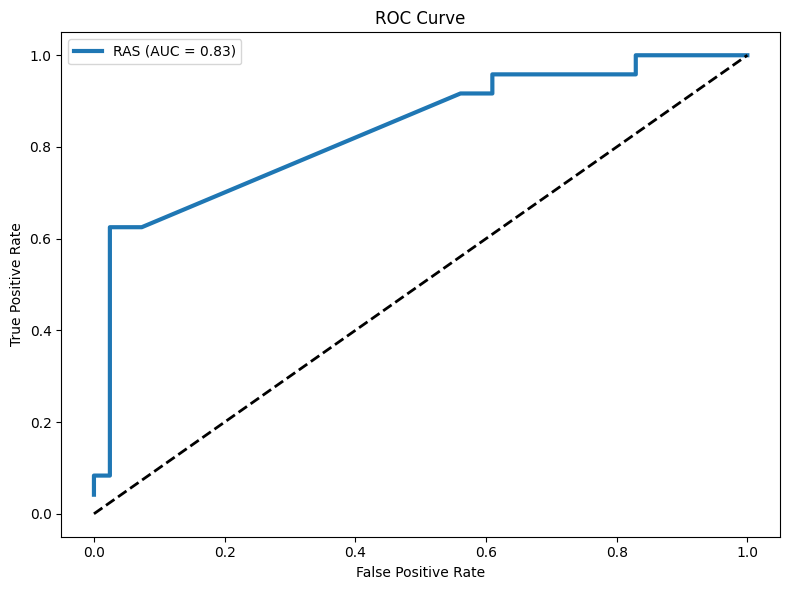


Training Elastic Net...
Best params for Elastic Net: {'model__C': 0.1, 'model__l1_ratio': 0.5}
Best CV ROC-AUC: 0.8009

Training Random Forest...
Best params for Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
Best CV ROC-AUC: 0.8845

Training GBM...
Best params for GBM: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.8152

Training Decision Tree...
Best params for Decision Tree: {'model__max_depth': None, 'model__min_samples_leaf': 2}
Best CV ROC-AUC: 0.7756

Training XGBoost...
Best params for XGBoost: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 1.0}
Best CV ROC-AUC: 0.8598


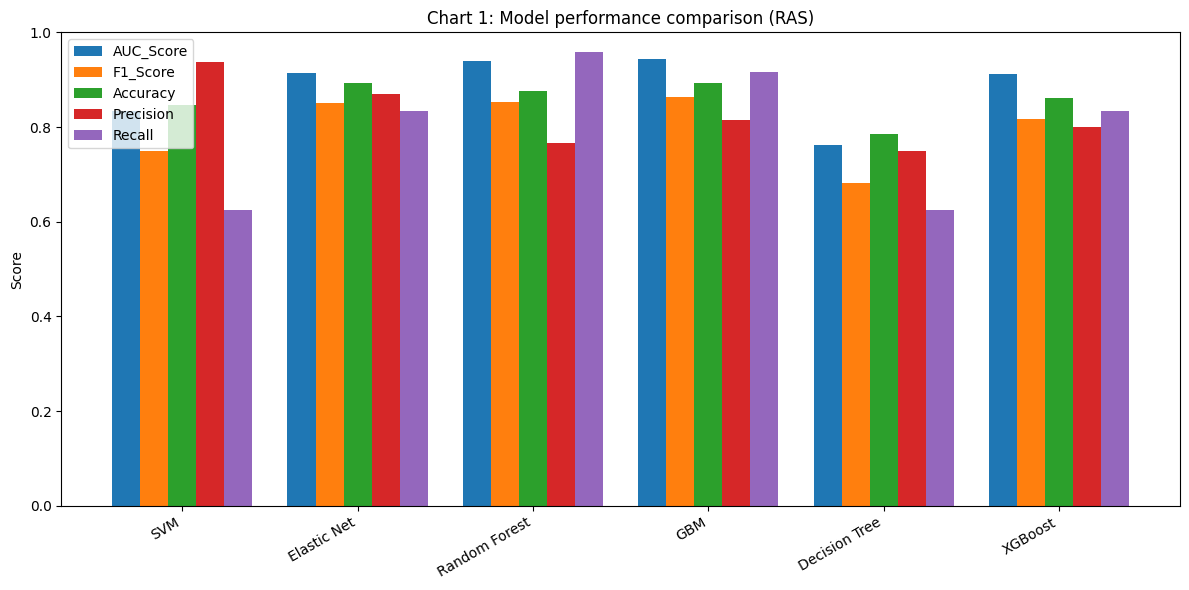

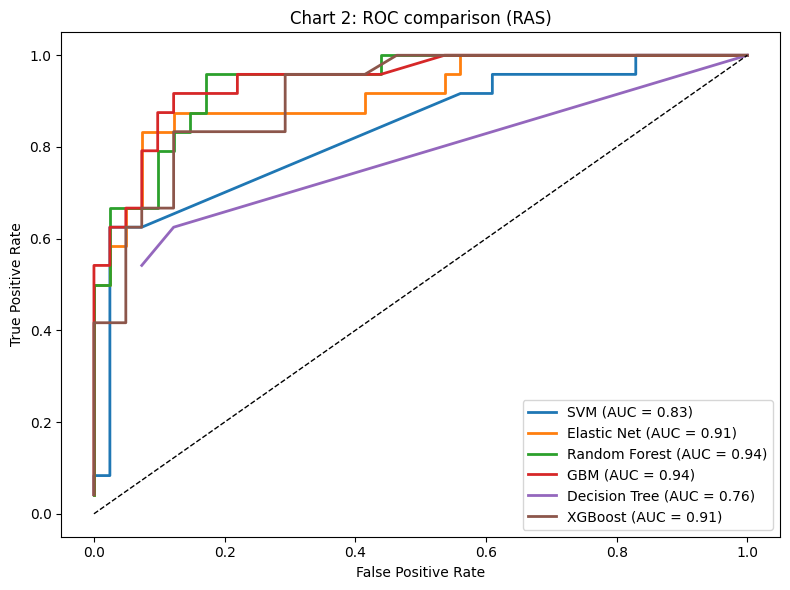

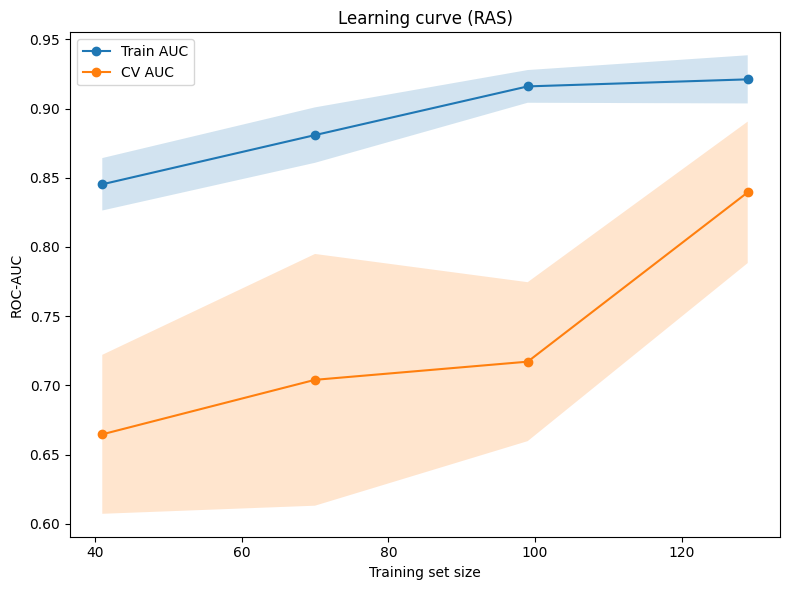

Running SHAP on a small sample for explainability...


  0%|          | 0/20 [00:00<?, ?it/s]

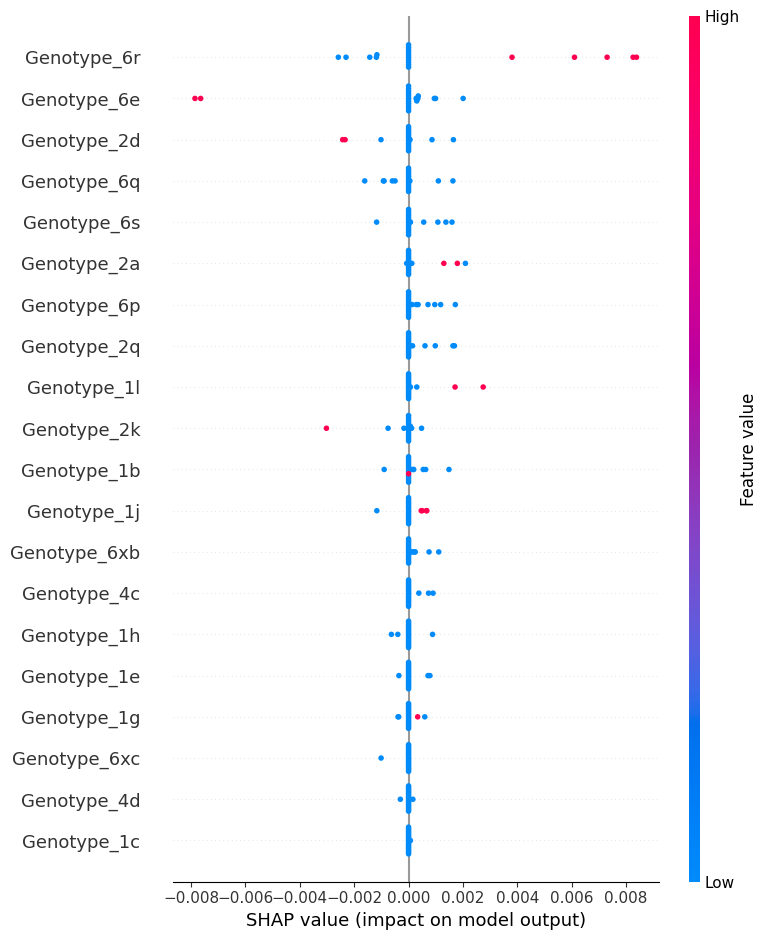

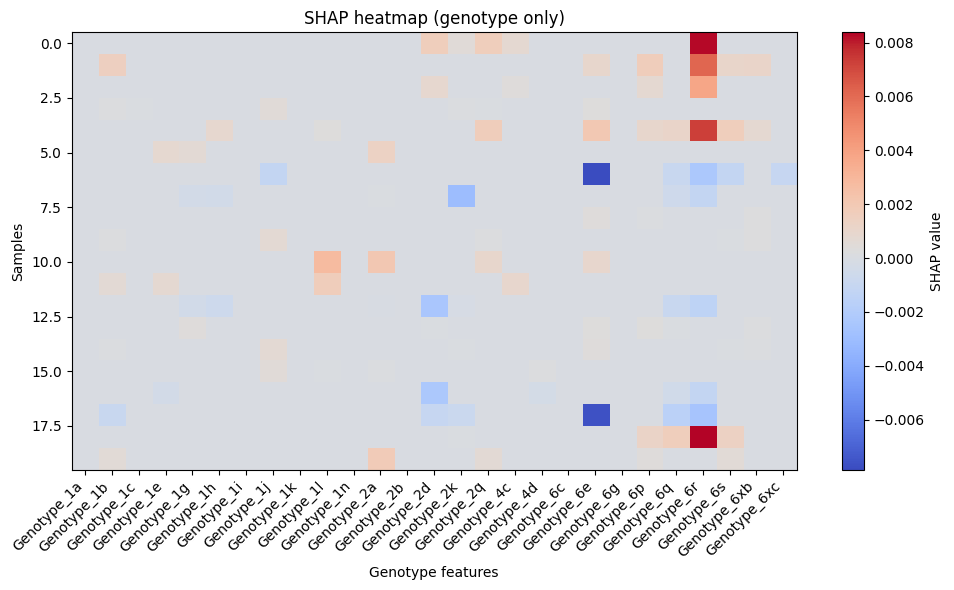

In [44]:
ras_path = "data/data_RAS.xlsx"

run_dir = os.path.join("outputs", "Experiment_Model_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

ras_significance = analyze_ras_significance(ras_path)

X, y, ras_df, ras_features, feature_names = build_feature_matrix(
    ras_path,
    ras_sheet="Sheet1",
)

results = train_and_evaluate_models(
    X,
    y,
    seq_df=ras_df,
    feature_names=feature_names,
    label="RAS",
    save_path=run_dir,
)

plot_model_comparisons(
    results,
    label="RAS",
    save_path=run_dir,
)

svm_model = results["models"].get("SVM", {}).get("model") if results.get("models") else None
if svm_model is not None:
    plot_learning_curve(
        svm_model,
        X,
        y,
        label="RAS",
        save_path=run_dir,
    )
else:
    print("SVM model unavailable; skipping learning curve.")

svm_result = results["models"].get("SVM") if results.get("models") else None
if svm_result:
    explain_with_shap(
        svm_result["model"],
        results["X_train"],
        results["X_test"],
        feature_names=results["feature_names"],
        save_path=run_dir,
        label="RAS",
    )
else:
    print("SVM results unavailable; skipping SHAP explainability.")
